In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
import skimage.io
import scipy
import importlib

import Colony_Analysis as ca
import Plate_Shuffling as ps

from scipy import stats

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


## SC liquid confirmation

## BTX stability experiment:


In [15]:
path='liquid_data/BTX_stability.23.4.10/'
plate_map = pd.read_csv(path +'plate_map.csv').iloc[:,1:4]
plate_map 


,1,2,3
0,SC_Blank,SC_Blank,SC_Blank
1,ScBTX20_A,ScBTX20_A,ScBTX20_A
2,ScBTX20_B,ScBTX20_B,ScBTX20_B
3,ScBTX20_C,ScBTX20_C,ScBTX20_C
4,ScBTX21_A,ScBTX21_A,ScBTX21_A
5,ScBTX21_B,ScBTX21_B,ScBTX21_B
6,ScBTX21_C,ScBTX21_C,ScBTX21_C
7,Empty,Empty,Empty


In [18]:
#generate data frame:
plate_map.values.reshape(-1)
cols, rows = np.meshgrid(np.arange(plate_map.shape[1]),np.arange(plate_map.shape[0]))
cols, rows = cols.reshape(-1), rows.reshape(-1)
Data=pd.DataFrame(np.vstack([plate_map.values.reshape(-1),rows,cols]).T, columns=['strain','row','col' ])

volume_measured = 200 #uL the volume you used when doing the plate read out
OD_dilution_factor = 1 #the dilution of the plate with 
volume_measured = volume_measured *10**(-9)  #m^3, 1uL = 10^(-9) m^3
path='liquid_data/BTX_stability.23.4.10/data/'

for time in ['H0','H24', 'H48','H72', 'H96', 'H168']:
    file_name = time +'.xlsx'
    for i, metric in enumerate(['OD','fluo1', 'fluo2','fluo3']):
        
        data= pd.read_excel(path+ file_name, sheet_name='Plate 1 - Sheet1',skiprows=41).values[i::4,2:-10]
        
        Data[metric +'.'+time] = data.reshape(-1)


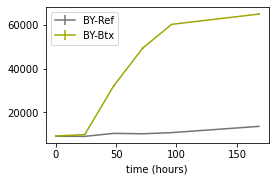

In [19]:
#plot relative OD over time

fig, ax = plt.subplots(figsize=(4,2.5))

fluo_metric='fluo2.'
DF=Data.copy()
data_dict={}
for strain in ['ScBTX20','ScBTX21']:
    Fluo = []
    Fluo_std = []
    OD = []
    OD_std = []
    for time in ['H0','H24','H48','H72', 'H96', 'H168']:


        fluo = []
        fluo_std = []
        od = []
        od_std = []
        for r in ['_A','_B','_C']:
                i= DF.strain.isin([strain +r]) 
                fluo.append(DF[i][fluo_metric+time].values.mean())
                fluo_std.append(DF[i][fluo_metric+time].values.std())
                od.append(DF[i]['OD.'+time].values.mean())
                od_std.append(DF[i]['OD.'+time].values.std())
        Fluo.append(fluo)
        Fluo_std.append(fluo_std)
        OD.append(od)
        OD_std.append(od_std)
    Fluo = np.stack(Fluo) #time, replicate
    Fluo_std = np.stack(Fluo_std) 
    OD = np.stack(OD) 
    OD_std = np.stack(OD_std) 
    data_dict[strain+'.OD']=OD
    data_dict[strain+'.OD_std']=OD_std
    data_dict[strain+'.Fluo']=Fluo
    data_dict[strain+'.Fluo_std']=Fluo_std
    

color={'ScBTX20':[109/255,119/255,109/255],'ScBTX21':[158/255,167/255,0]}
label={'ScBTX20':'BY-Ref','ScBTX21':'BY-Btx'}
for i,strain in enumerate(['ScBTX20','ScBTX21']):
    
    y=data_dict[strain+'.Fluo']
    time =np.array([int(t[1:]) for t in ['H0','H24','H48','H72', 'H96', 'H168']])
    time=time.reshape(-1,1).repeat(3,1)
    yerr=data_dict[strain+'.Fluo_std']
    ax.errorbar(x=time[:,1],y=y[:,1], yerr=yerr[:,1],color=color[strain], label=label[strain])
ax.set_xlabel('time (hours)')
ax.set_label('Fluorescence (AU)')
ax.legend()

## Final time point experiment, figure 6

work woth data from 31.10.22 see  BTX_liquid_confirmation.ipynb for full analysis

In [26]:
## load data
data_path ='Liquid_Data/'

Plate_reader_all_colonies  = pd.read_csv(data_path +'QD.csv', sep=',')
Plate_reader = pd.read_csv(data_path +'GA.csv', sep=',')
# changes the name of the BTX WT in df to 'WT'
Plate_reader.loc[Plate_reader.gene =='BTX WT CONTROL','gene'] = 'WT'
CRISPA = pd.read_csv('GA1_2_4_6.csv',sep=',')

# we replace gene names with homonymes we have used
CRISPA.loc[CRISPA.gene == 'PPA1','gene']='VMA16'
#HEM25 is called YDL119C we change this:
CRISPA.loc[CRISPA.gene == 'YDL119C','gene'] = 'HEM25'


#load individual read outs
CRISPA_QD = pd.read_csv('QD1_2_4_6.csv',
                       sep=',')
# we replace gene names with homonymes we have used
CRISPA_QD.loc[CRISPA_QD.gene == 'PPA1','gene']='VMA16'
#HEM25 is called YDL119C we change this:
CRISPA_QD.loc[CRISPA_QD.gene == 'YDL119C','gene'] = 'HEM25'

In [33]:
strain2gene ={
'Sc_BTX07':'DLD2',
'Sc_BTX08':'KGD2',
'Sc_BTX09':'MIP1',
'Sc_BTX11':'RCR2',
'Sc_BTX12':'SGM1',
'Sc_BTX13':'SHY1',
'Sc_BTX14':'VPS34',
'Sc_BTX16':'YER084W',
'Sc_BTX18':'COX12',
'Sc_BTX20':'No BTX control',
'Sc_BTX21':'WT',
'Sc_BTX22':'HEM25',
'Sc_BTX24':'PRO2',
'Sc_BTX25':'VMA16',
'Sc_BTX27':'GET4',
'Sc_BTX28':'PRY1',
'Sc_BTX29':'STV1',
'Sc_BTX30':'YCR101C',
'Sc_BTX31':'YLR271W',
'Sc_BTX32':'GLR1',
'Sc_BTX51':'QCR10',
'Sc_BTX52':'SSM4',
'Sc_BTX53':'UBC7',
'Sc_BTX55':'RPN4'}

gene2strain={}
for strain, gene  in strain2gene.items():
    gene2strain[gene] =strain

### Record significances in CRI-SPA scores and SC with Welch's test

In [34]:
#create a dict storing {gene:[CRISPA p-value,CRISPA t-value,  SC p-value , SC t-value ]}

signif_dic={}
for gene in group_select:
    signif_dic[gene]=['na','na','na','na']


    
    

DF = CRISPA_QD.copy()
metric =  'corrected_mean_intensity.24'
for gene in group_select:
    
    gene_scores = DF[DF.gene == gene][metric]
    WT_scores  =DF[DF.gene == 'WT'][metric]
    i_nan=( WT_scores.isna()==0)
    WT_scores =WT_scores[i_nan]
    i_nan=( gene_scores.isna()==0)

    gene_scores=gene_scores[i_nan]
    #determine whether we test for more or less than WT:
    alternative = 'less'  if np.mean(WT_scores)> np.mean(gene_scores) else 'greater' 
         
    t, p = scipy.stats.ttest_ind(gene_scores, WT_scores,equal_var=False
                                 ,alternative=alternative) #Welch test cause sample ≠ variances
   # print(gene_scores)
    signif_dic[gene][0]=p
    signif_dic[gene][1]=t
 #   print(gene,alternative, np.round(p,3),np.round(np.mean(gene_scores),2), np.round(np.mean(WT_scores),2))
    
    
# two sided t-test for all genes vs WT:
DF = Plate_reader_all_colonies.copy()
metric =  'SC_Resuspended_Fluo3'
count=0
for gene in group_select:
    
    gene_scores = DF[DF.gene == gene2strain[gene]][metric]
    WT_scores  =DF[DF.gene == gene2strain['WT']][metric]
    #alternative{‘two-sided’, ‘less’, ‘greater’}
    #determine whether we test for more or less than WT:
    alternative = 'less'  if np.mean(WT_scores)> np.mean(gene_scores) else 'greater' 
    t, p = scipy.stats.ttest_ind( gene_scores, WT_scores,equal_var=False
                                 ,alternative=alternative) #Welch test cause sample ≠ variances
    signif_dic[gene][2]=p
    signif_dic[gene][3]=t
    print(gene,alternative, np.round(p,3),np.round(np.mean(gene_scores),2), np.round(np.mean(WT_scores),2))

    if (alternative == 'greater') and p<0.05 :
        count+=1
        print(gene)
    
#create a gene color dict:

green = [29/255,177/255,0]
blue=[0,165/255,255/255]

grey=[146/255,146/255,146/255]
red = [1,0,0]
orange=[242/255,155/255,0]

gene_color_dic= {}
for gene, (crispa_p,crispa_t, SC_p, SC_t) in signif_dic.items():
    
    gene_color_dic[gene]=[0,0,0]

    if (crispa_p< 0.05) &(SC_p< 0.05): # both significant
        if crispa_t*SC_t<0:
            gene_color_dic[gene] =red #disagree
        else:
            gene_color_dic[gene]=green #dagree
            
    elif (crispa_p> 0.05) &(SC_p< 0.05): #CRISPA:NS SC:S
        gene_color_dic[gene]=blue
    elif (crispa_p< 0.05) &(SC_p> 0.05): #CRISPA:S SC:NS
        gene_color_dic[gene] = orange
    elif (crispa_p> 0.05) &(SC_p> 0.05): #CRISPA:NS SC:NS
        gene_color_dic[gene] = grey
    #check that difference signs agree:
    print(crispa_t,SC_t)
    #SC >wt and CRISPA > wt


        

DLD2 greater 0.115 324.33 261.33
KGD2 less 0.341 243.33 261.33
MIP1 greater 0.027 396.0 261.33
MIP1
RCR2 greater 0.136 325.0 261.33
SGM1 greater 0.034 378.67 261.33
SGM1
SHY1 greater 0.045 370.33 261.33
SHY1
VPS34 less 0.056 162.33 261.33
YER084W greater 0.015 452.0 261.33
YER084W
COX12 greater 0.01 494.0 261.33
COX12
HEM25 less 0.041 152.33 261.33
PRO2 greater 0.177 306.67 261.33
VMA16 greater 0.049 362.0 261.33
VMA16
GET4 greater 0.017 414.33 261.33
GET4
PRY1 greater 0.04 378.67 261.33
PRY1
STV1 greater 0.126 351.0 261.33
YCR101C greater 0.18 324.0 261.33
YLR271W greater 0.188 305.67 261.33
GLR1 greater 0.011 439.67 261.33
GLR1
QCR10 greater 0.063 352.33 261.33
SSM4 greater 0.001 681.0 261.33
SSM4
RPN4 greater 0.081 387.0 261.33
UBC7 greater 0.002 581.33 261.33
UBC7
WT greater 0.5 261.33 261.33
1.0682481326320252 1.5619301310203726
-7.33827940550112 -0.4692814278557396
3.095715726723239 3.305484595451096
3.7046261008415065 1.273729666446528
2.321946562938076 2.6961506843573018
6.6783

In [36]:
group_select=['DLD2','KGD2','MIP1','RCR2','SGM1','SHY1','VPS34','YER084W','COX12'
,'HEM25','PRO2','VMA16','GET4','PRY1','STV1','YCR101C','YLR271W','GLR1',
'QCR10','SSM4','RPN4','UBC7','WT'] #

Bottom_color=[209/255,219/255,209/255]
Top_color=[158/255,167/255,0/255]


### Highlights the genes hits on the CRISPA screen data

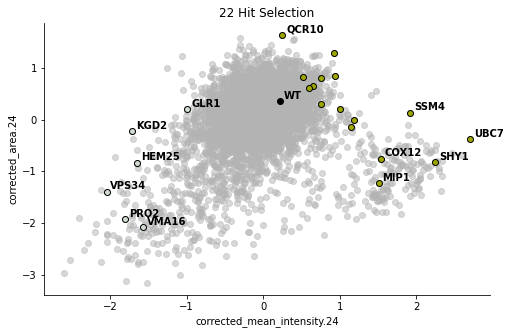

In [39]:

X_df=  CRISPA.copy()
Y_df=  CRISPA.copy()
x_metric = 'corrected_mean_intensity.24'
y_metric = 'corrected_area.24'
color_metric = 'plate'

gate = ((X_df[x_metric+'_mean'].isna()==0 ) &(Y_df[y_metric+'_mean'].isna()==0 ) ) 
#gate  =  gate & (X_df[metric+'_std'] <0.12) #some very noisy points in WT screens are removed

Y = Y_df[y_metric+'_mean'][gate]
X=  X_df[x_metric+'_mean'][gate]
Xstd=  X_df[x_metric+'_std'][gate]
Ystd=  Y_df[y_metric+'_std'][gate]


G=  X_df['gene'][gate]


fig, axs= plt.subplots( figsize=(8,5))


#add size difference as marker size:
axs.scatter(X,Y, alpha=0.5,color=[0.7,0.7,0.7])
#axs[0].plot([0.6,1.2],[0.6,1.2])
##plots sub group of genes:
axs.set_ylabel(y_metric )
axs.set_xlabel(x_metric )
axs.set_title(x_metric )
axs.set_title(str(len(group_select)-1 ) +' Hit Selection')

axs.set_xlabel(x_metric)
axs.set_ylabel(y_metric)

#group_select= Top_genes 
#group_select = G[Y-0.4 > 1*(X-0.3)**0.5]
i_select =X_df[gate]['gene'].isin([str(g) for g in group_select])


#annotate selected genes:
for i, gene in enumerate(X_df[gate][i_select]['gene']):

    i_select = X_df['gene'][gate].isin([gene])
    anno_x=X[i_select].values
    anno_y=Y[i_select].values
    
    #color points
    if gene in ['KGD2','VPS34','HEM25','PRO2','VMA16','GLR1']:
        color=Bottom_color
    elif gene in ['DLD2','KGD2','MIP1','RCR2','SGM1','SHY1','YER084W','COX12','GET4','PRY1','STV1','YCR101C','YLR271W',
    'QCR10','SSM4','RPN4','UBC7','RCR2']:
        color=Top_color
    else:
        color='k'
    axs.scatter(anno_x,anno_y, color=color,edgecolors=[0,0,0] )
    if gene not in ['PRY1','DLD2','STV1','YCR101C','YLR271W','RCR2','SGM1','GET4','RPN4','YER084W' ]:
        axs.annotate(gene, (anno_x+0.05,anno_y+0.05), fontsize=10,weight='bold')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

plt.show()

#### plot inset

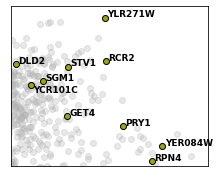

In [42]:
## create inset,SGM1
X_df=  CRISPA.copy()
Y_df=  CRISPA.copy()
x_metric = 'corrected_mean_intensity.24'
y_metric = 'corrected_area.24'
color_metric = 'plate'

gate = ((X_df[x_metric+'_mean'].isna()==0 ) &(Y_df[y_metric+'_mean'].isna()==0 ) ) 
#gate  =  gate & (X_df[metric+'_std'] <0.12) #some very noisy points in WT screens are removed

Y = Y_df[y_metric+'_mean'][gate]
X=  X_df[x_metric+'_mean'][gate]
Xstd=  X_df[x_metric+'_std'][gate]
Ystd=  Y_df[y_metric+'_std'][gate]


G=  X_df['gene'][gate]


fig, axs= plt.subplots( figsize=(6/1.7,5/1.7))


#add size difference as marker size:
axs.scatter(X,Y, alpha=0.3,color=[0.7,0.7,0.7])
#axs[0].plot([0.6,1.2],[0.6,1.2])
##plots sub group of genes:


#group_select= Top_genes 
#group_select = G[Y-0.4 > 1*(X-0.3)**0.5]
i_select =X_df[gate]['gene'].isin([str(g) for g in group_select])




group_select=['DLD2','KGD2','MIP1','RCR2','SGM1','SHY1','VPS34','YER084W','COX12'
,'HEM25','PRO2','VMA16','GET4','PRY1','STV1','YCR101C','YLR271W','GLR1',
'QCR10','SSM4','RPN4','UBC7','RCR2','WT'] #
#annotate selected genes:
for i, gene in enumerate(['PRY1','DLD2','STV1','YCR101C','YLR271W','RCR2','SGM1','GET4','RPN4','YER084W' ]):

    i_select = X_df['gene'][gate].isin([gene])
    anno_x=X[i_select].values
    anno_y=Y[i_select].values
    color= Top_color
    axs.scatter(anno_x,anno_y, color=color,edgecolors=[0,0,0] )
    adjust = -0.08 if gene== 'YCR101C' else 0
    
    axs.annotate(gene, (anno_x+0.01 ,anno_y+0.01+adjust ), fontsize=9,weight='bold')

axs.set_ylim([-0.2,1.4])
axs.set_xlim([0.5,1.4])


axs.set_xticks([])
axs.set_yticks([])

plt.show()

### Plot CRISPA Score vs Liquid fluo score

PCC:  (0.6804596103846007, 0.00025318268457186595)


[Text(0.5738814661248315, 327.333333333333, 'DLD2'),
 Text(-1.6573566745539337, 246.333333333333, 'KGD2'),
 Text(1.5595250583194282, 399.0, 'MIP1'),
 Text(0.9862241988063261, 328.0, 'RCR2'),
 Text(0.6977124952771792, 381.666666666667, 'SGM1'),
 Text(2.296831684795932, 373.333333333333, 'SHY1'),
 Text(-1.9952576017263388, 165.333333333333, 'VPS34'),
 Text(1.2436349592566298, 455.0, 'YER084W'),
 Text(1.589791642440297, 497.0, 'COX12'),
 Text(-1.597008609493748, 155.333333333333, 'HEM25'),
 Text(-1.75335509182426, 309.666666666667, 'PRO2'),
 Text(-1.516433582121832, 365.0, 'VMA16'),
 Text(0.8076053299869578, 417.333333333333, 'GET4'),
 Text(1.061897347322115, 381.666666666667, 'PRY1'),
 Text(0.810538765711186, 354.0, 'STV1'),
 Text(0.6439678844888143, 327.0, 'YCR101C'),
 Text(0.9802314862515105, 308.666666666667, 'YLR271W'),
 Text(-0.9412277643361467, 442.666666666667, 'GLR1'),
 Text(0.299768804158512, 355.333333333333, 'QCR10'),
 Text(1.9727534993763025, 684.0, 'SSM4'),
 Text(1.196239280

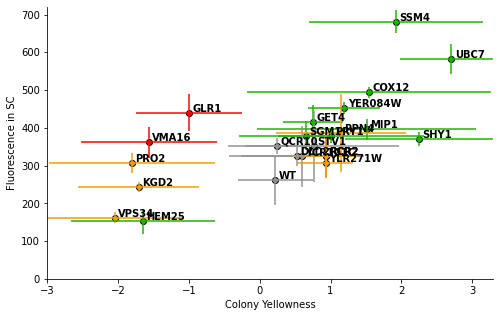

In [50]:
## Plot comparison with BTX screen:
##Plot CRISPA vs KO results


#VMA16 is called PPA1 we change this:
CRISPA.loc[CRISPA.gene == 'PPA1','gene']='VMA16'
#HEM25 is called YDL119C we change this:
CRISPA.loc[CRISPA.gene == 'YDL119C','gene'] = 'HEM25'


X = []
Y =[]
Xerr=[]
Yerr=[]
G=[]
S=[]
x_metric = 'corrected_mean_intensity.24'
y_metric =  'SC_Resuspended_Fluo3'

X_DF= CRISPA.copy()
Y_DF = Plate_reader.copy()
Not_in_CRISPA =[]

for gene in group_select:
    good =((X_DF.gene == gene).sum() >=1) & ((Y_DF.gene == gene).sum() >=1)


    if good:
        x=X_DF[X_DF.gene == gene][x_metric +'_mean']
        X.append(x)
        Xerr.append(X_DF[X_DF.gene == gene][x_metric +'_std'])
        y=Y_DF[Y_DF.gene == gene][y_metric +'_mean']
        Y.append(y)
        Yerr.append(Y_DF[Y_DF.gene == gene][y_metric +'_std'])
        g = gene #+'.'+gene2strain[gene][-2:]
        G.append(g)
        S.append(gene2strain[gene])
    else:
        Not_in_CRISPA.append(gene)
    
X=np.stack(X).squeeze()
Xerr = np.stack(Xerr).squeeze()
Y = np.stack(Y).squeeze()
Yerr = np.stack(Yerr).squeeze()

print('PCC: ',stats.pearsonr(X[pd.isna(Y)==0],Y[pd.isna(Y)==0]))


fig, axs= plt.subplots( figsize=(8,5))
color =['k' for _ in range(len(G))]
for i, gene in enumerate(G):
    #if gene in ['KGD2','VPS34','HEM25','PRO2','VMA16','GLR1']:
    #    color=Bottom_color
    #    alpha=1
    #elif gene in ['DLD2','KGD2','MIP1','RCR2','SGM1','SHY1','YER084W','COX12','GET4','PRY1','STV1','YCR101C','YLR271W',
    #'QCR10','SSM4','RPN4','UBC7','RCR2']:
    #    color=Top_color
    #    alpha=0.6
    #else:
    #    color='k'
    #    alpha=1
    color= gene_color_dic[gene]
    #we do two layers, one for point edge and second for errorbar and alpha
    axs.scatter(X[i],y=Y[i], color=color, edgecolors=[0,0,0])
    axs.errorbar(x=X[i],y=Y[i],xerr=Xerr[i],yerr=Yerr[i],c=color, alpha=1, fmt="." )
axs.set_ylabel('Fluorescence in SC')
axs.set_xlabel('Colony Yellowness')
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
#axs.set_title()
axs.set_ylim([0,720])
xlims=[-3,3.3]
axs.set_xlim(xlims)

[axs.annotate(G, (x+0.05,y+3),weight='bold') for (G,x,y) in  zip(G ,list(X),list(Y))]




### add control
#for gene in  ['NO BTX CONTROL']: #Not_in_CRISPA: 'OEX PRO2','OEX VMA16',
#    y= Y_DF[Y_DF.gene == gene][y_metric +'_mean'].values[0]
#    ystd= Y_DF[Y_DF.gene == gene][y_metric +'_std'].values[0]
#    print(y)
#    axs.axhline(y,linewidth='2', color=[0.4,0.4,0.4])
#    axs.axhline(y-ystd,linewidth='1', color=[0.4,0.4,0.4])#mean
#    axs.axhline(y+ystd,linewidth='1', color=[0.4,0.4,0.4])#mean
#    axs.annotate('BY4741 Control', (xlims[0]+0.1,y+4),weight='bold')
#    axs.fill_between(xlims,y-ystd,y+ystd, color=[0.4,0.4,0.4], alpha=.2)


In [18]:
#UBC/WT
print('UBC7/WT',584.33/264.33)
print('SSM4/WT',684/264.33)
print('HEM25/WT',155/264.33)

UBC7/WT 2.210607952180986
SSM4/WT 2.5876744977868573
HEM25/WT 0.5863882268376651


In [30]:
for gene, (crispa_p,crispa_t, SC_p, SC_t) in signif_dic.items():
    print(gene,crispa_p,SC_p  <0.05)

DLD2 0.14796313163784652 False
KGD2 5.210418213534089e-08 False
MIP1 0.00292819719059756 True
RCR2 0.0006180483282338409 False
SGM1 0.01546667986793302 True
SHY1 3.9091867426541086e-07 True
VPS34 1.4866494545028238e-08 False
YER084W 2.8816547094405155e-05 True
COX12 0.004804700088973557 True
HEM25 3.4885352865326415e-06 True
PRO2 1.7129961966722353e-06 False
VMA16 1.6007206032385006e-06 True
GET4 0.0050444137896638805 True
PRY1 0.026731496709983135 True
STV1 0.06883873885227904 False
YCR101C 0.09514145685991035 False
YLR271W 0.0004364133017054893 False
GLR1 2.2489043341645412e-05 True
QCR10 0.4458658017231972 False
SSM4 5.284668098130159e-05 True
RPN4 0.0012977413377907522 False
UBC7 1.0225146617439666e-10 True
WT 0.5 False


#### plot inset

PCC:  (0.5297645534079141, 0.034808429185790114)


[]

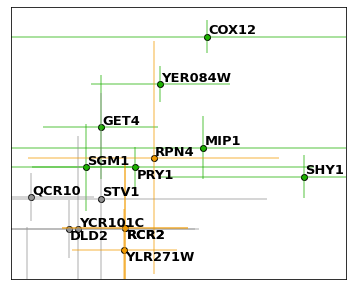

In [45]:
## Plot comparison with BTX screen:
##Plot CRISPA vs KO results


#VMA16 is called PPA1 we change this:
CRISPA.loc[CRISPA.gene == 'PPA1','gene']='VMA16'
#HEM25 is called YDL119C we change this:
CRISPA.loc[CRISPA.gene == 'YDL119C','gene'] = 'HEM25'

X = []
Y =[]
Xerr=[]
Yerr=[]
G=[]
S=[]
x_metric = 'corrected_mean_intensity.24'
y_metric =  'SC_Resuspended_Fluo3'

X_DF= CRISPA.copy()
Y_DF = Plate_reader.copy()
Not_in_CRISPA =[]
sub_select=['DLD2','MIP1','RCR2','SGM1','SHY1','YER084W','COX12'
,'GET4','PRY1','STV1','YCR101C','YLR271W','QCR10','RPN4','RCR2','WT']
for gene in sub_select:
    good =((X_DF.gene == gene).sum() >=1) & ((Y_DF.gene == gene).sum() >=1)


    if good:
        x=X_DF[X_DF.gene == gene][x_metric +'_mean']
        X.append(x)
        Xerr.append(X_DF[X_DF.gene == gene][x_metric +'_std'])
        y=Y_DF[Y_DF.gene == gene][y_metric +'_mean']
        Y.append(y)
        Yerr.append(Y_DF[Y_DF.gene == gene][y_metric +'_std'])
        g = gene #+'.'+gene2strain[gene][-2:]
        G.append(g)
        S.append(gene2strain[gene])
    else:
        Not_in_CRISPA.append(gene)
    
X=np.stack(X).squeeze()
Xerr = np.stack(Xerr).squeeze()
Y = np.stack(Y).squeeze()
Yerr = np.stack(Yerr).squeeze()

print('PCC: ',stats.pearsonr(X[pd.isna(Y)==0],Y[pd.isna(Y)==0]))


fig, axs= plt.subplots( figsize=(6,5))
color =['k' for _ in range(len(G))]
for i, gene in enumerate(G):

    color= gene_color_dic[gene]
    #we do two layers, one for point edge and second for errorbar and alpha
    axs.scatter(X[i],y=Y[i], color=color, edgecolors=[0,0,0])
    axs.errorbar(x=X[i],y=Y[i],xerr=Xerr[i],yerr=Yerr[i],c=color, alpha=0.5, fmt="." )

#axs.set_title()
axs.set_ylim([280,520])
axs.set_xlim([0.1,2.55])
for (gene,x,y) in  zip(G ,list(X),list(Y)):
    adjust = -12 if gene in ['DLD2', 'PRY1', 'RCR2','YLR271W'] else 0
    axs.annotate(gene, (x+0.01,y+2+adjust),weight='bold', fontsize=13) 



axs.set_xticks([])
axs.set_yticks([])



In [560]:
#print CRI-SPA Score:
DF = CRISPA.copy()
x_metric = 'corrected_mean_intensity.24'
y_metric = 'corrected_area.24'
X=[]
Y=[]
G=np.array(['WT','DLD2','KGD2','MIP1','RCR2','SGM1','VPS34','YER084W','COX12','HEM25','PRO2','VMA16','GET4'
,'PRY1','STV1','YCR101C','YLR271W','GLR1','QCR10','SSM4','UBC7','RPN4'])
for gene in G:
    x = DF[DF.gene == gene][x_metric+'_mean'].values[0]
    y = DF[DF.gene == gene][y_metric+'_mean'].values[0]
    X.append(np.round(x,2))
    Y.append(np.round(y,2))
    
pd.DataFrame(np.vstack([G,Y,X]).T)

,0,1,2
0,WT,0.35,0.22
1,DLD2,0.82,0.52
2,KGD2,-0.23,-1.71
3,MIP1,-1.23,1.51
4,RCR2,0.85,0.94
5,SGM1,0.65,0.65
6,VPS34,-1.39,-2.05
7,YER084W,-0.0,1.19
8,COX12,-0.75,1.54
9,HEM25,-0.83,-1.65
